<h1 style='font-size: 35px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'> Bootstrapping and Resampling Techniques</h1>

---

This notebook contains Python scripts and sample data for performing bootstrapping and resampling techniques. It demonstrates how to estimate confidence intervals, evaluate statistical variability, and support robust inference using resampling method

In [2]:
# Import Required Libraries and Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 10) 
filepath = "../Datasets/Soil Health.csv"
df = pd.read_csv(filepath)
display(df)

,Location,Soil pH,Soil Moisture (%),Soil Organic Matter (%),Soil Nitrogen Content (mg/kg),Soil Phosphorus Content (mg/kg),Soil Potassium Content (mg/kg),Average Daily Temperature (⁰C),Total Rainfall (mm),Crop Yield (tons/ha)
0,West,5.87,38.00,3.19,2407.00,31.60,480.00,26.70,1200.00,8.72
1,Central,6.42,43.90,5.17,1702.00,78.10,293.00,23.40,822.00,7.60
2,East,7.53,44.30,3.93,1545.00,61.00,357.00,20.10,601.00,6.53
3,Central,5.71,26.20,4.78,1541.00,34.20,383.00,20.60,1200.00,6.53
4,Central,7.17,45.50,3.41,1371.00,57.20,125.00,27.20,954.00,6.92
...,...,...,...,...,...,...,...,...,...,...
95,East,6.58,20.00,3.98,1371.00,37.10,320.00,21.10,1147.00,5.80
96,Central,7.20,11.60,4.30,300.00,36.90,240.00,24.90,1108.00,3.62
97,South,6.61,22.10,2.79,1366.00,5.80,430.00,26.30,1009.00,5.52
98,South,6.08,31.50,1.84,1241.00,52.00,237.00,24.70,400.00,4.48


In [3]:
# Dataset Profilling
def column_summary(df):
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df
    
summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Location,object,0,100,5,"{'West': 26, 'South': 21, 'Central': 19, 'Nort..."
1,Soil pH,float64,0,100,80,"{5.91: 3, 6.4: 3, 6.44: 2, 6.42: 2, 7.02: 2, 5..."
2,Soil Moisture (%),float64,0,100,84,"{36.8: 3, 43.9: 2, 45.5: 2, 33.2: 2, 22.2: 2, ..."
3,Soil Organic Matter (%),float64,0,100,94,"{4.34: 3, 3.35: 2, 3.45: 2, 3.18: 2, 4.79: 2, ..."
4,Soil Nitrogen Content (mg/kg),float64,0,100,94,"{1371.0: 2, 2295.0: 2, 1824.0: 2, 1062.0: 2, 1..."
5,Soil Phosphorus Content (mg/kg),float64,0,100,91,"{52.0: 3, 17.2: 2, 43.8: 2, 43.4: 2, 37.1: 2, ..."
6,Soil Potassium Content (mg/kg),float64,0,100,87,"{364.0: 3, 376.0: 3, 212.0: 3, 132.0: 2, 279.0..."
7,Average Daily Temperature (⁰C),float64,0,100,73,"{18.0: 4, 32.0: 4, 22.5: 3, 22.7: 3, 28.4: 2, ..."
8,Total Rainfall (mm),float64,0,100,77,"{400.0: 10, 1200.0: 4, 1139.0: 3, 601.0: 2, 87..."
9,Crop Yield (tons/ha),float64,0,100,92,"{5.65: 3, 6.53: 2, 5.29: 2, 5.78: 2, 7.67: 2, ..."


- Now, let's move forward and apply bootstrapping to the soil parameters data in order to gain a clearer overview of their statistical behavior. Bootstrapping is a powerful resampling technique that allows us to estimate the distribution of a sample statistic—such as the mean—by repeatedly sampling from the data with replacement. This method is especially useful when the underlying distribution is unknown or when the sample size is relatively small. By running this process thousands of times, we can construct a more robust estimate of the central tendency and variability of each parameter. 

- In addition to calculating the means, we will also compute the confidence intervals (CI) for each soil parameter. These intervals give us a sense of the uncertainty around the mean estimates, helping us better understand the reliability and potential variation within our soil data. This overview will be essential in identifying which parameters are more stable and which ones vary significantly, offering deeper insight into the soil's condition and suitability for agricultural decision-making.


In [6]:
def bootstrapping(df, column, num_samples=1000, sample_size=30):
    sample_means = []
    for _ in range(num_samples):
        sample = df[column].dropna().sample(n=sample_size, replace=True)
        sample_means.append(sample.mean())
    return np.array(sample_means)

def bootstrapping_summary(df, group_col=None, numeric_cols=None, num_samples=1000, sample_size=30): 
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        if group_col in numeric_cols:
            numeric_cols.remove(group_col)
    
    results = []

    if group_col: grouped = df.groupby(group_col)
    else: grouped = [(None, df)]

    for group_name, group_df in grouped:
        for col in numeric_cols:
            bootstrap_means = bootstrapping(group_df, col, num_samples, sample_size)
            true_mean = group_df[col].mean()
            
            ci_lower = np.percentile(bootstrap_means, 2.5)
            ci_upper = np.percentile(bootstrap_means, 97.5)
            bootstrap_mean = np.mean(bootstrap_means)

            results.append({
                'Group': group_name if group_col else 'Overall',
                'Variable': col,
                #'True Mean': round(true_mean, 4),
                'Sample Mean': round(bootstrap_mean, 4),
                'CI Lower (95%)': round(ci_lower, 4),
                'CI Upper (95%)': round(ci_upper, 4)
            })

    return pd.DataFrame(results)

results = bootstrapping_summary(
    df = df, 
    group_col=None, 
    numeric_cols=None, 
    num_samples=1000, 
    sample_size=30)

display(results)

,Group,Variable,Sample Mean,CI Lower (95%),CI Upper (95%)
0,Overall,Soil pH,6.52,6.27,6.77
1,Overall,Soil Moisture (%),30.15,26.14,34.24
2,Overall,Soil Organic Matter (%),4.15,3.64,4.67
3,Overall,Soil Nitrogen Content (mg/kg),1442.19,1259.06,1628.60
4,Overall,Soil Phosphorus Content (mg/kg),42.25,36.55,48.12
5,Overall,Soil Potassium Content (mg/kg),320.43,278.05,361.90
6,Overall,Average Daily Temperature (⁰C),24.93,23.61,26.17
7,Overall,Total Rainfall (mm),821.65,738.53,905.36
8,Overall,Crop Yield (tons/ha),5.96,5.51,6.40


- In addition to analyzing the overall distribution of soil parameters, we will also perform bootstrapping within each group defined by the **"Location"** column. This allows us to estimate the sampling distribution of the mean for each soil parameter separately by location, helping us understand how these parameters vary across different geographical areas. By resampling within each group and calculating the mean multiple times, we can generate confidence intervals for each location-specific mean. These intervals provide valuable insights into where the true population mean is likely to lie for each parameter within each location.

- This grouped analysis helps us compare soil quality and characteristics between different locations more confidently. It also allows us to identify which locations have more consistent soil properties and which ones show greater variability. Ultimately, this grouped bootstrapping overview supports more localized and precise agricultural recommendations, as we can better understand how soil conditions differ by area and how reliable our estimates are for each group.


In [7]:
results = bootstrapping_summary(
    df = df, 
    group_col='Location', 
    numeric_cols=None, 
    num_samples=1000, 
    sample_size=30)

display(results)

,Group,Variable,Sample Mean,CI Lower (95%),CI Upper (95%)
0,Central,Soil pH,6.53,6.34,6.74
1,Central,Soil Moisture (%),33.01,28.33,37.60
2,Central,Soil Organic Matter (%),4.21,3.72,4.66
3,Central,Soil Nitrogen Content (mg/kg),1564.21,1382.48,1739.18
4,Central,Soil Phosphorus Content (mg/kg),47.50,41.71,53.56
5,Central,Soil Potassium Content (mg/kg),297.87,249.70,346.90
6,Central,Average Daily Temperature (⁰C),24.38,23.15,25.59
7,Central,Total Rainfall (mm),817.65,723.03,911.05
8,Central,Crop Yield (tons/ha),6.46,6.03,6.92
9,East,Soil pH,6.63,6.40,6.86



To gain a more **visual and intuitive understanding**, we will now create **histograms** of the **bootstrapped sample means** for each soil parameter. Histograms are especially effective for showing the **distribution** of the resampled means, giving us a sense of how the estimates are spread and where the central tendency lies.

**For each soil parameter, the histogram will illustrate:**

* The **shape of the sampling distribution** (e.g., whether it’s symmetric, skewed, or multimodal)
* The **concentration of values** around the mean
* The **range of plausible values** for the parameter based on resampling

In addition to the histogram, we will overlay **vertical lines** indicating the **mean of the bootstrapped samples** as well as the **confidence interval bounds** (e.g., the 2.5th and 97.5th percentiles). This combination helps us clearly see not only where the average value lies but also how much uncertainty surrounds that estimate.

C:\Users\user\AppData\Local\Temp\ipykernel_7264\1371653449.py:40: UserWarning: Glyph 8304 (\N{SUPERSCRIPT ZERO}) missing from font(s) Maiandra GD.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8304 (\N{SUPERSCRIPT ZERO}) missing from font(s) Maiandra GD.
  fig.canvas.print_figure(bytes_io, **kw)


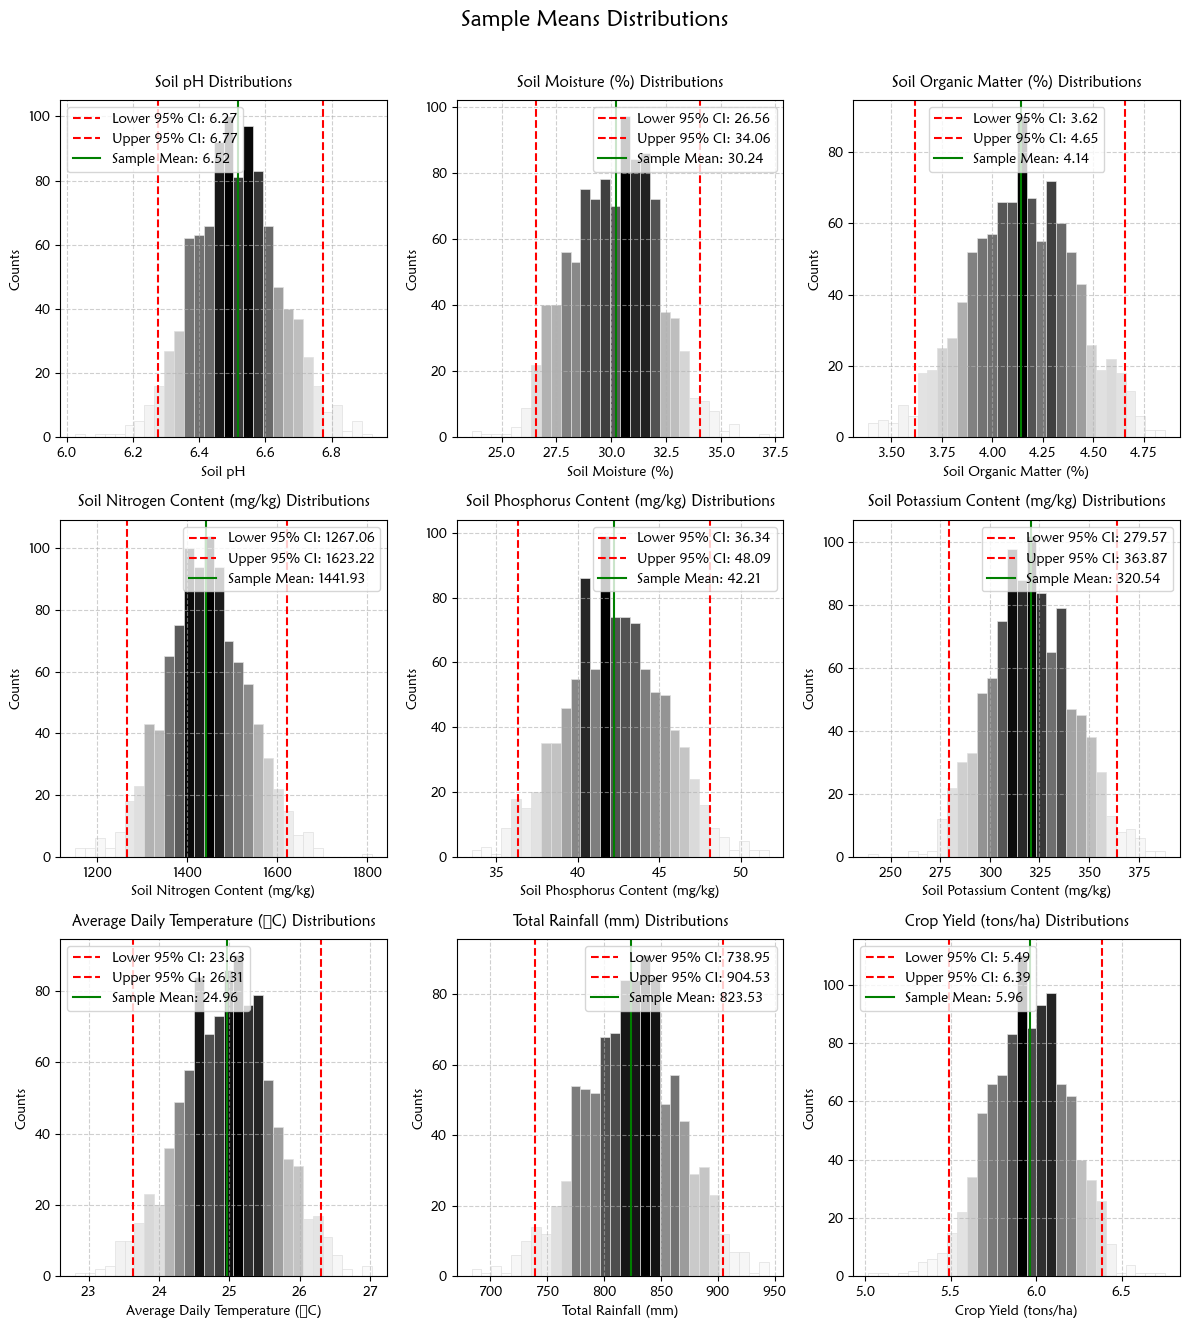

In [9]:
def compute_confidence_interval(bootstrap_means, confidence_level=95):     # - For 95% CI:
    lower_percentile = (100 - confidence_level) / 2                        #   - Lower bound = 2.5th percentile
    upper_percentile = 100 - lower_percentile                              #    - Upper bound = 97.5th percentile
    ci_lower = np.percentile(bootstrap_means, lower_percentile)            # - This gives us the interval in which the true average yield is likely to lie.
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    return ci_lower, ci_upper


def plot_histoplot(data, numeric_cols=None):
    if numeric_cols is None: numeric_cols = data.select_dtypes(include='number').columns.tolist()    
        
    num_variables = len(numeric_cols)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Maiandra GD', 'font.style': 'normal', 'font.size': 10 })
    fig.suptitle("Sample Means Distributions", fontsize=16, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(numeric_cols):
        ax = axes[idx]
        bootstrap_means = bootstrapping(data, column)
        sample_mean = np.mean(data[column])
        ci_lower, ci_upper = compute_confidence_interval(bootstrap_means, confidence_level=95)
        n, bins, patches = ax.hist(bootstrap_means, bins=30, edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
        
        for i in range(len(patches)): patches[i].set_facecolor(plt.cm.Grays(n[i] / max(n)))
        axes[idx].axvline(ci_lower, color='red', linestyle='--', label=f'Lower 95% CI: {ci_lower:.2f}')
        axes[idx].axvline(ci_upper, color='red', linestyle='--', label=f'Upper 95% CI: {ci_upper:.2f}')
        axes[idx].axvline(sample_mean, color='green', linestyle='-', label=f'Sample Mean: {sample_mean:.2f}')
  
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Counts')
        axes[idx].legend(frameon=True)
        
    for idx in range(num_variables, len(axes)):fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
fig = plot_histoplot(df)
#fig.savefig(f'../Outputs/Variables Distribution.png')

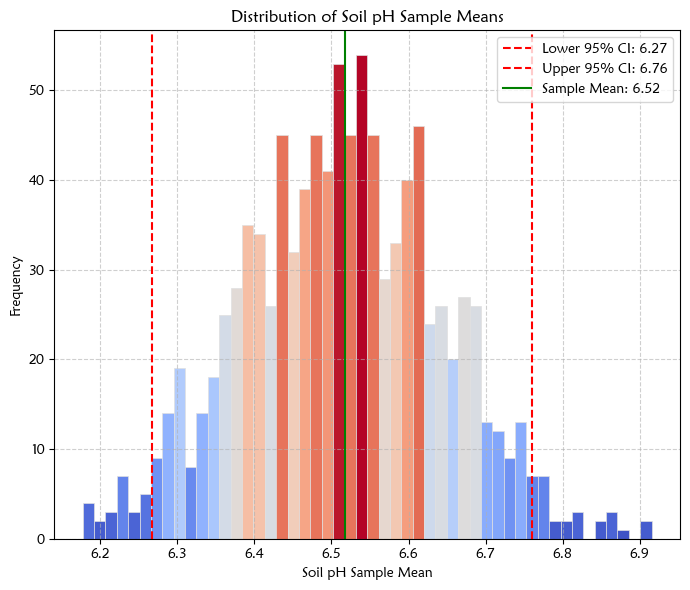

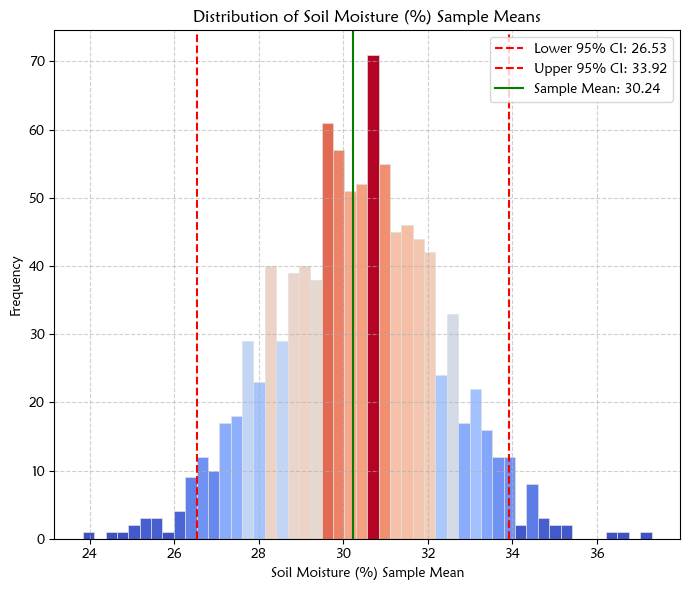

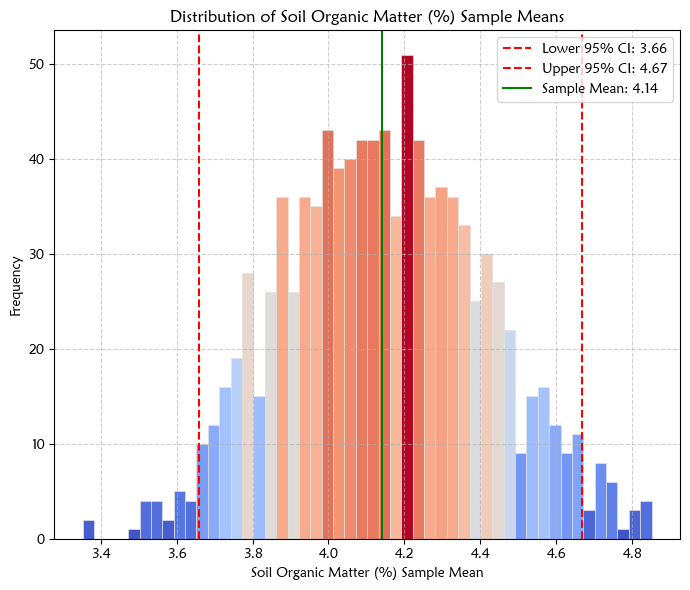

In [11]:
def plot_bootstrap_distribution(bootstrap_means, ci_lower, ci_upper, sample_mean, column=None):
    fig, ax = plt.subplots(figsize=(7, 6))
    n, bins, patches = ax.hist(bootstrap_means, bins=50, edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
    plt.rcParams.update({'font.family': 'Maiandra GD', 'font.style': 'normal', 'font.size': 10 })
    for i in range(len(patches)): patches[i].set_facecolor(plt.cm.coolwarm(n[i] / max(n)))
        
    plt.axvline(ci_lower, color='red', linestyle='--', label=f'Lower 95% CI: {ci_lower:.2f}')
    plt.axvline(ci_upper, color='red', linestyle='--', label=f'Upper 95% CI: {ci_upper:.2f}')
    plt.axvline(sample_mean, color='green', linestyle='-', label=f'Sample Mean: {sample_mean:.2f}')
    
    if column: plt.title(f'Distribution of {column} Sample Means', fontfamily='Maiandra GD')
    else: plt.title('Distribution of Sample Means', fontfamily='Capitalist')
    if column: plt.xlabel(f'{column} Sample Mean')
        
    else: plt.xlabel('Sample Mean')
    plt.grid(linestyle='--', alpha=0.6)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return fig

    
for idx, column in enumerate(df.select_dtypes(include=[np.number]).columns[:3]):
    bootstrap_means = bootstrapping(df, column)                               # Step 2: Bootstrap resampling
    ci_lower, ci_upper = compute_confidence_interval(bootstrap_means)         # Step 3: Compute 95% confidence interval
    sample_mean = np.mean(df[column])                                           # Step 4: Calculate the actual sample mean
    fig = plot_bootstrap_distribution(
        bootstrap_means = bootstrap_means, 
        ci_lower = ci_lower, 
        ci_upper = ci_upper, 
        sample_mean = sample_mean,
        column = column)
    fig.savefig(f'../Outputs/00000-00{idx} HISTOGRAM.png')
    

---

This analysis was performed by **Jabulente**, a passionate and dedicated data analyst with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

---

<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>

<h1 style='font-size: 55px; color: red; font-family: Colonna MT; font-weight: 700; text-align: center'>THE END</h1>